In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid

from recsys4daos.models import NLPSimilarity
from recsys4daos.utils import Timer
from recsys4daos.datasets import to_microsoft
from recsys4daos.evaluation import calculate_all_metrics
from recsys4daos.model_selection import cvtt_open, explore_hparams

import paths

import seaborn as sns
sns.set_theme()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/daviddavo/recsys4daos/.direnv/python-3.11/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Parameters

In [2]:
# Dataset config
ORG_NAME = 'Decentraland'

# Evaluation
K_RECOMMENDATIONS: list[int] = [1,3,5,10,15,100]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_FOLDS = 10 # Use just last 10 splits
LAST_FOLD_DATE_STR: str = None

# Search space config
WINDOW_SIZES = ['7d', '14d', '21d', '30d', '60d', '90d', '10YE']
MODEL_NAMES = [
    'all-mpnet-base-v2', # The one used in sbert's examples
    'all-distilroberta-v1',
    'all-MiniLM-L12-v2',
    'all-MiniLM-L6-v2',
]

OPTIM_METRIC = 'map@10'

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "Lido"
SPLITS_FREQ = "W-WED"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2022-07-06"


In [4]:
EMBEDDINGS_CACHE = Path(paths.DEFAULT_CACHE_PATH) / 'pln-embeddings'

# Load the dataset

In [5]:
dfp = paths.load_proposals(ORG_NAME, text=True)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 223 non-null    object        
 1   author             223 non-null    object        
 2   date               223 non-null    datetime64[us]
 3   start              223 non-null    datetime64[us]
 4   end                223 non-null    datetime64[us]
 5   platform_proposal  223 non-null    object        
 6   title              223 non-null    object        
 7   description        223 non-null    object        
dtypes: datetime64[us](3), object(5)
memory usage: 14.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56473 entries, 0 to 56472
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        56473 non-null  object        
 1   proposal  56473 non-null  obje

In [6]:
df = to_microsoft(dfv)
df

,userID,itemID,timestamp,rating
0,0x68335b3ac272c8238b722963368f87de736b64d6,cda99ddd-8555-5c25-ba90-433bc3495f45,2021-02-02 07:26:45,1
1,0xc0afef712a1341ca78da145b2afad346e8c3574f,cda99ddd-8555-5c25-ba90-433bc3495f45,2021-02-02 09:26:08,1
2,0x11099ac9cc097d0c9759635b8e16c6a91ecc43da,cda99ddd-8555-5c25-ba90-433bc3495f45,2021-02-02 10:43:28,1
3,0xdcddb68e99aac82b649ac15b82530c2b7f079e9f,cda99ddd-8555-5c25-ba90-433bc3495f45,2021-02-02 15:58:10,1
4,0x10b05dd4cf5decf597bbd831a3c4bc2f9bf51fb0,cda99ddd-8555-5c25-ba90-433bc3495f45,2021-02-02 16:12:08,1
...,...,...,...,...
56468,0x7821f8b55d58d508ced1dd4ce031f0985ce1e46a,df19148b-6dd0-55b0-abb3-eb172d7b7cdb,2023-06-29 17:58:25,1
56469,0xa094e287128d62e6e872daba552ac139bae71354,a136bcda-9842-52c9-a070-4922625067d0,2023-06-29 17:58:37,1
56470,0xa094e287128d62e6e872daba552ac139bae71354,df19148b-6dd0-55b0-abb3-eb172d7b7cdb,2023-06-29 17:59:00,1
56471,0xf7aa189442b2d5cc4846a363892f15ff8b15f41c,3e2ac59f-c78f-57d5-b442-744af4ff6549,2023-06-29 17:59:13,1


## Split in folds

In [7]:
all_folds = { f.end:f for f in cvtt_open(
    df, SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', last_fold=LAST_FOLD_DATE_STR,
)}
last_folds_idx = list(all_folds.keys())[-LAST_FOLDS:]
last_folds_idx

[Timestamp('2022-05-04 00:00:00'),
 Timestamp('2022-05-11 00:00:00'),
 Timestamp('2022-05-18 00:00:00'),
 Timestamp('2022-05-25 00:00:00'),
 Timestamp('2022-06-01 00:00:00'),
 Timestamp('2022-06-08 00:00:00'),
 Timestamp('2022-06-15 00:00:00'),
 Timestamp('2022-06-22 00:00:00'),
 Timestamp('2022-06-29 00:00:00'),
 Timestamp('2022-07-06 00:00:00')]

# Similarity PLN

In [8]:
def testHParamsPLNSimilarity(fold, window_size, model_name):
    f = all_folds[fold]
    
    model = NLPSimilarity(dfp, EMBEDDINGS_CACHE, model_name=model_name)

    offset = pd.tseries.frequencies.to_offset(window_size)
    train = f.train[f.train['timestamp'] > (f.end - offset)]

    with Timer() as t_fit:
        model.fit(train)

    with Timer() as t_rec:
        # Truncate the top_k
        top_k = max(K_RECOMMENDATIONS)
        users = np.intersect1d(f.test['userID'].unique(), train['userID'].unique())
        recs = model.recommend_k_items(users, top_k=min(len(f.open_proposals), top_k), recommend_from=f.open_proposals)
    
    return {
        'time_train': t_fit.time,
        'time_rec': t_rec.time,
        'rec_users': len(users),
        **calculate_all_metrics(f.test, recs, K_RECOMMENDATIONS),
    }

# testHParamsPLNSimilarity(last_folds_idx[0], '14D', MODEL_NAMES[0])

In [9]:
# Populate the cache of embeddings for each model
from recsys4daos.models.nlp import NLPModel

for m in MODEL_NAMES:
    NLPModel(dfp, EMBEDDINGS_CACHE, model_name=m).fit()

In [10]:
results = explore_hparams(
    testHParamsPLNSimilarity,
    ParameterGrid({
        'fold': last_folds_idx,
        'model_name': MODEL_NAMES,
        'window_size': WINDOW_SIZES,
    }),
    paths.hparams_progress('pln-similarity', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE),
)
mdf = pd.DataFrame(results)
mdf

Restored checkpoint from ../.cache/Lido/hparams-pln-similarity_W-WED_normalize.pkl with 308 results


  0%|          | 0/280 [00:00<?, ?it/s]

,fold,model_name,window_size,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
0,2022-05-04,all-mpnet-base-v2,7d,0.083226,0.000367,0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068442
1,2022-05-04,all-mpnet-base-v2,14d,0.235151,0.001194,1,1.000000,0.333333,0.200000,0.100000,...,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.119004
2,2022-05-04,all-mpnet-base-v2,21d,0.251184,0.001363,29,1.000000,0.333333,0.200000,0.100000,...,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.126344
3,2022-05-04,all-mpnet-base-v2,30d,0.111378,0.001412,32,1.000000,0.333333,0.200000,0.100000,...,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.126143
4,2022-05-04,all-mpnet-base-v2,60d,0.272529,0.001376,33,1.000000,0.333333,0.200000,0.100000,...,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.126646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2022-07-06,all-MiniLM-L6-v2,21d,0.395707,0.002614,300,0.713333,0.546667,0.328000,0.164000,...,1.0,1.0,1.0,0.707165,0.841085,0.841085,0.841085,0.841085,0.841085,0.189312
276,2022-07-06,all-MiniLM-L6-v2,30d,0.442130,0.010880,320,0.734375,0.544792,0.326875,0.163438,...,1.0,1.0,1.0,0.686525,0.890977,0.890977,0.890977,0.890977,0.890977,0.195508
277,2022-07-06,all-MiniLM-L6-v2,60d,0.465768,0.005671,344,0.735465,0.543605,0.326163,0.163081,...,1.0,1.0,1.0,0.678524,0.923214,0.923214,0.923214,0.923214,0.923214,0.193672
278,2022-07-06,all-MiniLM-L6-v2,90d,0.671250,0.003153,364,0.752747,0.540293,0.324176,0.162088,...,1.0,1.0,1.0,0.690389,0.918605,0.918605,0.918605,0.918605,0.918605,0.198260


<Axes: xlabel='window_size', ylabel='map@10'>

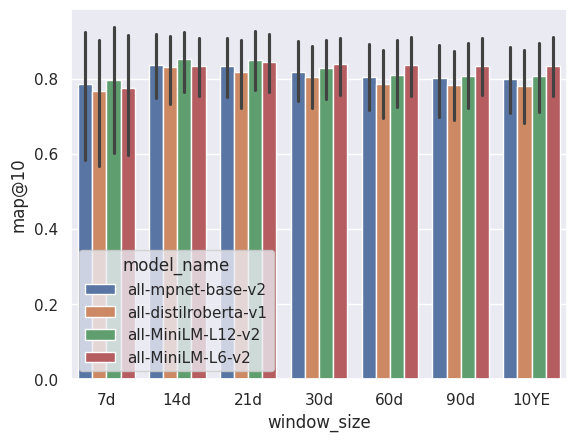

In [11]:
sns.barplot(mdf, x='window_size', y=OPTIM_METRIC, hue='model_name')

## Best overall hparams

In [12]:
display_columns = ['time_train'] + [ c for c in mdf.columns if c.endswith('@5') or c.endswith('@10') or c.endswith('@100') ]
hparam_cols = ['window_size', 'model_name']
overall_hparams = mdf[mdf['fold'] > last_folds_idx[0]].groupby(hparam_cols).mean().sort_values(OPTIM_METRIC, ascending=False)
overall_hparams[display_columns]

time_train  precision@5  precision@10  \
window_size model_name                                                    
7d          all-MiniLM-L12-v2       0.203861     0.242537      0.121268   
            all-mpnet-base-v2       0.218645     0.242537      0.121268   
            all-MiniLM-L6-v2        0.201701     0.241659      0.120830   
            all-distilroberta-v1    0.252947     0.242244      0.121122   
14d         all-MiniLM-L12-v2       0.229414     0.249954      0.124977   
21d         all-MiniLM-L12-v2       0.279862     0.247931      0.123965   
            all-MiniLM-L6-v2        0.279220     0.247382      0.123691   
30d         all-MiniLM-L6-v2        0.334485     0.246368      0.123184   
14d         all-mpnet-base-v2       0.269030     0.249954      0.124977   
60d         all-MiniLM-L6-v2        0.382096     0.245479      0.122739   
90d         all-MiniLM-L6-v2        0.399250     0.245081      0.122540   
21d         all-mpnet-base-v2       0.322358     0.247931      0.123965   
14d         all-MiniLM-L6-v2        0.260819     0.249398      0.124699   
10YE        all-MiniLM-L6-v2        0.453931     0.244818      0.122409   
14d         all-distilroberta-v1    0.271921     0.249676      0.124838   
30d         all-MiniLM-L12-v2       0.351762     0.246891      0.123445   
21d         all-distilroberta-v1    0.290983     0.247657      0.123828   
30d         all-mpnet-base-v2       0.350692     0.246891      0.123445   
60d         all-MiniLM-L12-v2       0.399263     0.245737      0.122869   
90d         all-MiniLM-L12-v2       0.400571     0.245339      0.122670   
10YE        all-MiniLM-L12-v2       0.454294     0.245076      0.122538   
60d         all-mpnet-base-v2       0.404017     0.245737      0.122869   
30d         all-distilroberta-v1    0.350419     0.246629      0.123315   
90d         all-mpnet-base-v2       0.438509     0.245339      0.122670   
10YE        all-mpnet-base-v2       0.531970     0.245076      0.122538   
60d         all-distilroberta-v1    0.423831     0.245221      0.122610   
90d         all-distilroberta-v1    0.457709     0.244822      0.122411   
10YE        all-distilroberta-v1    0.530696     0.244560      0.122280   

                                  precision@100    ndcg@5   ndcg@10  ndcg@100  \
window_size model_name                                                          
7d          all-MiniLM-L12-v2          0.012127  0.535283  0.535283  0.535283   
            all-mpnet-base-v2          0.012127  0.528282  0.528282  0.528282   
            all-MiniLM-L6-v2           0.012083  0.523911  0.523911  0.523911   
            all-distilroberta-v1       0.012112  0.518357  0.518357  0.518357   
14d         all-MiniLM-L12-v2          0.012498  0.667668  0.667668  0.667668   
21d         all-MiniLM-L12-v2          0.012397  0.724020  0.724020  0.724020   
            all-MiniLM-L6-v2           0.012369  0.719659  0.719659  0.719659   
30d         all-MiniLM-L6-v2           0.012318  0.768783  0.768783  0.768783   
14d         all-mpnet-base-v2          0.012498  0.656414  0.656414  0.656414   
60d         all-MiniLM-L6-v2           0.012274  0.846451  0.846451  0.846451   
90d         all-MiniLM-L6-v2           0.012254  0.855832  0.855832  0.855832   
21d         all-mpnet-base-v2          0.012397  0.713449  0.713449  0.713449   
14d         all-MiniLM-L6-v2           0.012470  0.654148  0.654148  0.654148   
10YE        all-MiniLM-L6-v2           0.012241  0.864242  0.864242  0.864242   
14d         all-distilroberta-v1       0.012484  0.652468  0.652468  0.652468   
30d         all-MiniLM-L12-v2          0.012345  0.761847  0.761847  0.761847   
21d         all-distilroberta-v1       0.012383  0.702192  0.702192  0.702192   
30d         all-mpnet-base-v2          0.012345  0.753660  0.753660  0.753660   
60d         all-MiniLM-L12-v2          0.012287  0.825757  0.825757  0.825757   
90d         all-MiniLM-L12-v2          0.012267  0.833119  0.833119  0.833119   
1

In [13]:
best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])
paths.save_model_results(best_avg_hparams, 'plnsim-best-avg', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_avg_hparams

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Lido/models/plnsim-best-avg_W-WED_normalize.parquet


/tmp/ipykernel_3820671/971293119.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])


,,,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
fold,window_size,model_name,,,,,,,,,,,,,,,,,,,,,
2022-05-04,7d,all-MiniLM-L12-v2,0.220277,0.000334,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068256
2022-05-11,7d,all-MiniLM-L12-v2,0.095880,0.001466,76,1.000000,0.521930,0.321053,0.160526,0.107018,0.016053,0.883721,...,1.0,1.0,1.0,0.730263,0.942982,0.949561,0.949561,0.949561,0.949561,0.131771
2022-05-18,7d,all-MiniLM-L12-v2,0.248184,0.001826,99,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,0.761538,...,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.153446
2022-05-25,7d,all-MiniLM-L12-v2,0.125139,0.001623,133,0.759398,0.451128,0.270677,0.135338,0.090226,0.013534,0.492683,...,1.0,1.0,1.0,0.770627,0.990099,0.990099,0.990099,0.990099,0.990099,0.139188
2022-06-01,7d,all-MiniLM-L12-v2,0.286915,0.001547,107,0.990654,0.348910,0.209346,0.104673,0.069782,0.010467,0.514563,...,1.0,1.0,1.0,0.976415,1.000000,1.000000,1.000000,1.000000,1.000000,0.135365
2022-06-08,7d,all-MiniLM-L12-v2,0.124158,0.001758,197,0.832487,0.470389,0.282234,0.141117,0.094078,0.014112,0.534202,...,1.0,1.0,1.0,0.753049,1.000000,1.000000,1.000000,1.000000,1.000000,0.148585
2022-06-15,7d,all-MiniLM-L12-v2,0.264603,0.001586,146,0.513699,0.342466,0.205479,0.102740,0.068493,0.010274,0.276753,...,1.0,1.0,1.0,0.973333,1.000000,1.000000,1.000000,1.000000,1.000000,0.141233
2022-06-22,7d,all-MiniLM-L12-v2,0.126535,0.001671,150,0.233333,0.360000,0.216000,0.108000,0.072000,0.010800,0.144628,...,1.0,1.0,1.0,0.880952,0.960526,0.960526,0.960526,0.960526,0.960526,0.141628
2022-06-29,7d,all-MiniLM-L12-v2,0.300340,0.001586,67,0.791045,0.353234,0.211940,0.105970,0.070647,0.010597,0.244240,...,1.0,1.0,1.0,0.962264,0.990566,0.990566,0.990566,0.990566,0.990566,0.132925


## best hparams by fold

In [14]:
print("Best hyperparams by fold", OPTIM_METRIC)
best_hparams = mdf.sort_values(OPTIM_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', 'model_name', 'window_size'])
paths.save_model_results(best_hparams, 'plnsim-best-val', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_hparams[display_columns]

Best hyperparams by fold map@10
Saved dataframe into /home/daviddavo/recsys4daos/data/output/Lido/models/plnsim-best-val_W-WED_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2022-05-04,all-mpnet-base-v2,14d,0.235151,0.200000,0.100000,0.010000,0.028571,0.028571,0.028571,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000
2022-05-11,all-MiniLM-L12-v2,7d,0.095880,0.321053,0.160526,0.016053,0.876808,0.876808,0.876808,0.983553,0.983553,0.983553,1.0,1.0,1.0,0.949561,0.949561,0.949561
2022-05-18,all-mpnet-base-v2,30d,0.147428,0.200000,0.100000,0.010000,0.938462,0.938462,0.938462,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000
2022-05-25,all-MiniLM-L6-v2,7d,0.123896,0.270677,0.135338,0.013534,0.625986,0.625986,0.625986,0.952381,0.952381,0.952381,1.0,1.0,1.0,0.991803,0.991803,0.991803
2022-06-01,all-MiniLM-L12-v2,7d,0.286915,0.209346,0.104673,0.010467,0.517626,0.517626,0.517626,0.995327,0.995327,0.995327,1.0,1.0,1.0,1.000000,1.000000,1.000000
2022-06-08,all-distilroberta-v1,7d,0.293673,0.282234,0.141117,0.014112,0.605125,0.605125,0.605125,0.923012,0.923012,0.923012,1.0,1.0,1.0,1.000000,1.000000,1.000000
2022-06-15,all-MiniLM-L6-v2,90d,0.505803,0.206667,0.103333,0.010333,0.836970,0.836970,0.836970,0.783333,0.783333,0.783333,1.0,1.0,1.0,1.000000,1.000000,1.000000
2022-06-22,all-MiniLM-L12-v2,21d,0.212390,0.218478,0.109239,0.010924,0.553438,0.553438,0.553438,0.631341,0.631341,0.631341,1.0,1.0,1.0,0.946429,0.946429,0.946429
2022-06-29,all-MiniLM-L6-v2,7d,0.293818,0.211940,0.105970,0.010597,0.284341,0.284341,0.284341,0.893035,0.893035,0.893035,1.0,1.0,1.0,1.000000,1.000000,1.000000


In [15]:
best_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.0,10.000000,10.000000,10.000000
mean,0.231647,0.238650,0.119325,0.011932,0.557496,0.557496,0.557496,0.910972,0.910972,0.910972,1.0,1.0,1.0,0.984651,0.984651,0.984651
std,0.122736,0.042764,0.021382,0.002138,0.288785,0.288785,0.288785,0.118441,0.118441,0.118441,0.0,0.0,0.0,0.023165,0.023165,0.023165
min,0.095880,0.200000,0.100000,0.010000,0.028571,0.028571,0.028571,0.631341,0.631341,0.631341,1.0,1.0,1.0,0.946429,0.946429,0.946429
25%,0.129779,0.207336,0.103668,0.010367,0.360133,0.360133,0.360133,0.900529,0.900529,0.900529,1.0,1.0,1.0,0.966988,0.966988,0.966988
50%,0.223770,0.215209,0.107605,0.010760,0.579281,0.579281,0.579281,0.950061,0.950061,0.950061,1.0,1.0,1.0,1.000000,1.000000,1.000000
75%,0.291984,0.269533,0.134766,0.013477,0.784224,0.784224,0.784224,0.992383,0.992383,0.992383,1.0,1.0,1.0,1.000000,1.000000,1.000000
max,0.505803,0.321053,0.160526,0.016053,0.938462,0.938462,0.938462,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000


### Results of using best hparams on next fold

In [16]:
next_hparams_idx = best_hparams.index.to_frame(False)
next_hparams_idx['fold'] = next_hparams_idx['fold'].shift(-1)
next_hparams_idx = next_hparams_idx.dropna()
assert len(next_hparams_idx) == len(best_hparams)-1
next_hparams = mdf.set_index(['fold', 'model_name', 'window_size']).loc[pd.MultiIndex.from_frame(next_hparams_idx)]
paths.save_model_results(next_hparams, 'plnsim-best-test', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
next_hparams[display_columns]

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Lido/models/plnsim-best-test_W-WED_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2022-05-11,all-mpnet-base-v2,14d,0.117656,0.320000,0.160000,0.016000,0.852269,0.852269,0.852269,0.880903,0.880903,0.880903,1.0,1.0,1.0,0.926768,0.926768,0.926768
2022-05-18,all-MiniLM-L12-v2,7d,0.248184,0.200000,0.100000,0.010000,0.761538,0.761538,0.761538,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000
2022-05-25,all-mpnet-base-v2,30d,0.351485,0.256842,0.128421,0.012842,0.803536,0.803536,0.803536,0.818860,0.818860,0.818860,1.0,1.0,1.0,0.927007,0.927007,0.927007
2022-06-01,all-MiniLM-L6-v2,7d,0.284278,0.209346,0.104673,0.010467,0.517626,0.517626,0.517626,0.995327,0.995327,0.995327,1.0,1.0,1.0,1.000000,1.000000,1.000000
2022-06-08,all-MiniLM-L12-v2,7d,0.124158,0.282234,0.141117,0.014112,0.600316,0.600316,0.600316,0.912860,0.912860,0.912860,1.0,1.0,1.0,1.000000,1.000000,1.000000
2022-06-15,all-distilroberta-v1,7d,0.279797,0.205479,0.102740,0.010274,0.442052,0.442052,0.442052,0.756849,0.756849,0.756849,1.0,1.0,1.0,1.000000,1.000000,1.000000
2022-06-22,all-MiniLM-L6-v2,90d,0.406855,0.215063,0.107531,0.010753,0.701902,0.701902,0.701902,0.608438,0.608438,0.608438,1.0,1.0,1.0,0.954545,0.954545,0.954545
2022-06-29,all-MiniLM-L12-v2,21d,0.379240,0.210256,0.105128,0.010513,0.546320,0.546320,0.546320,0.674679,0.674679,0.674679,1.0,1.0,1.0,0.982456,0.982456,0.982456
2022-07-06,all-MiniLM-L6-v2,7d,0.261263,0.266102,0.133051,0.013305,0.294956,0.294956,0.294956,0.896186,0.896186,0.896186,1.0,1.0,1.0,0.954545,0.954545,0.954545


In [17]:
next_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.0,9.0,9.000000,9.000000,9.000000
mean,0.272546,0.240591,0.120296,0.012030,0.613391,0.613391,0.613391,0.838234,0.838234,0.838234,1.0,1.0,1.0,0.971702,0.971702,0.971702
std,0.101596,0.042402,0.021201,0.002120,0.182893,0.182893,0.182893,0.136083,0.136083,0.136083,0.0,0.0,0.0,0.031473,0.031473,0.031473
min,0.117656,0.200000,0.100000,0.010000,0.294956,0.294956,0.294956,0.608438,0.608438,0.608438,1.0,1.0,1.0,0.926768,0.926768,0.926768
25%,0.248184,0.209346,0.104673,0.010467,0.517626,0.517626,0.517626,0.756849,0.756849,0.756849,1.0,1.0,1.0,0.954545,0.954545,0.954545
50%,0.279797,0.215063,0.107531,0.010753,0.600316,0.600316,0.600316,0.880903,0.880903,0.880903,1.0,1.0,1.0,0.982456,0.982456,0.982456
75%,0.351485,0.266102,0.133051,0.013305,0.761538,0.761538,0.761538,0.912860,0.912860,0.912860,1.0,1.0,1.0,1.000000,1.000000,1.000000
max,0.406855,0.320000,0.160000,0.016000,0.852269,0.852269,0.852269,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000
